<a href="https://colab.research.google.com/github/thawnglong/Projects-Portfolio/blob/main/Airbnb_Data_Analytics_EDA_with_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('DataScience_Milestone_Project')

Mounted at DataScience_Milestone_Project


# Get ready

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
porter = PorterStemmer()
porter.stem("changing")
stops = stopwords.words("english")
calendar = pd.read_csv('/content/DataScience_Milestone_Project/MyDrive/DataScience_Milestone_Project/calendar.csv')
listings = pd.read_csv('/content/DataScience_Milestone_Project/MyDrive/DataScience_Milestone_Project/listings.csv')
listings_sum = pd.read_csv('/content/DataScience_Milestone_Project/MyDrive/DataScience_Milestone_Project/listings_sum.csv')
reviews = pd.read_csv('/content/DataScience_Milestone_Project/MyDrive/DataScience_Milestone_Project/reviews.csv')
reviews_sum = pd.read_csv('/content/DataScience_Milestone_Project/MyDrive/DataScience_Milestone_Project/reviews_sum.csv')
neighbourhoods = pd.read_csv('/content/DataScience_Milestone_Project/MyDrive/DataScience_Milestone_Project/neighbourhoods.csv')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#drop non-use columns
listings.drop(columns=['listing_url','scrape_id','last_scraped','picture_url','source','host_url','host_thumbnail_url','host_picture_url','host_neighbourhood','neighbourhood','property_type','minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm','calendar_updated','calendar_last_scraped','host_listings_count','bathrooms','number_of_reviews_ltm','number_of_reviews_l30d','neighbourhood_group_cleansed','host_name','neighbourhood_group_cleansed','license','host_since','availability_30','availability_60','availability_90','availability_365','first_review','last_review','calculated_host_listings_count','calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms','host_location','host_about','host_response_time','host_response_rate','host_acceptance_rate','host_verifications','host_has_profile_pic','host_identity_verified','minimum_nights','maximum_nights','has_availability'],inplace= True)

In [ ]:
mile = listings.merge(listings_sum[['id','price']],how = 'outer',on = 'id')
mile.drop(columns=['price_x'],inplace = True)

In [ ]:
mile.rename(columns={'price_y':'price','neighbourhood_cleansed':'neighbourhood'},inplace = True)

In [ ]:
mile = mile[mile['price'] != 0]

In [ ]:
# listing per neighbourhood
count_neighbour = mile.groupby('neighbourhood')['id'].count().sort_values(ascending= False)

In [ ]:
# exclude outlier
mile = mile[mile['price']<80000]

# Milestone

## Insight 1: Location

In [ ]:
!pip install geopandas
import geopandas as gpd
local_df = pd.DataFrame(count_neighbour).reset_index()
local_df.columns = ['neighbourhood','count']
local_df.head()
local_geojson = 'http://data.insideairbnb.com/australia/vic/melbourne/2022-12-10/visualisations/neighbourhoods.geojson'
localjson_data = gpd.read_file(local_geojson)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 91.0 MB/s eta 0:00:00


In [ ]:
map = localjson_data.merge(local_df, on='neighbourhood', how='left')

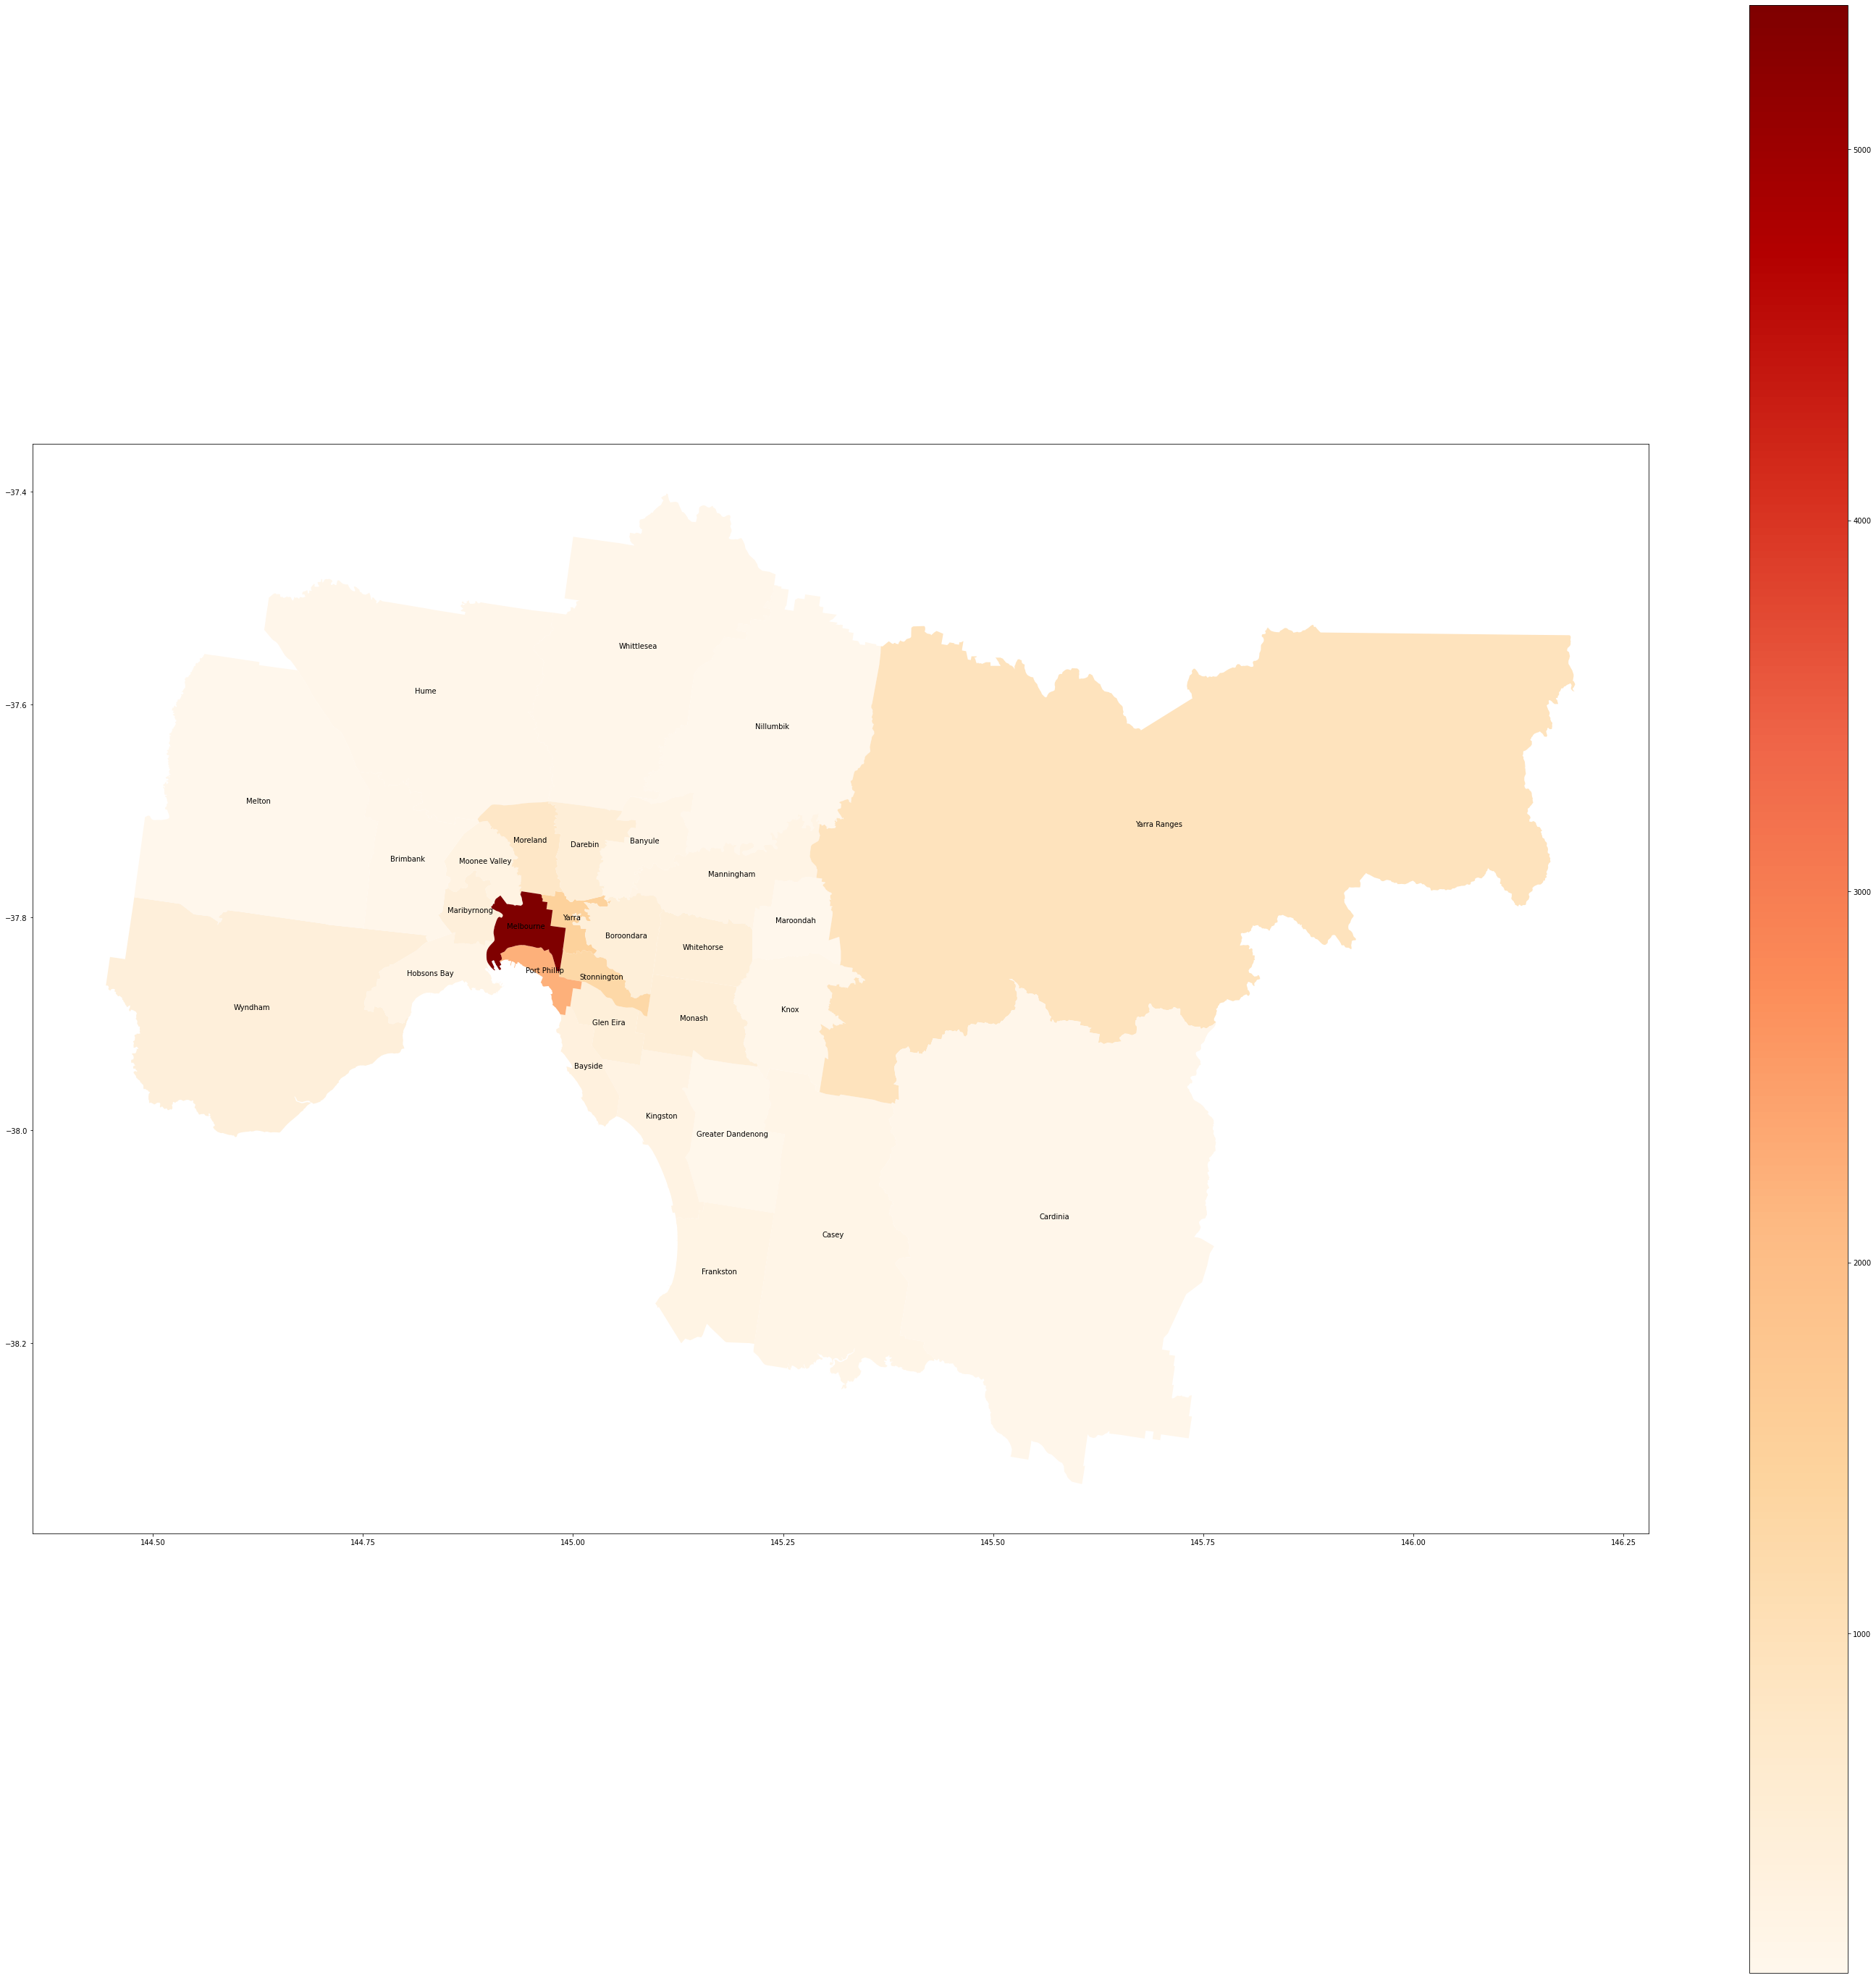

In [ ]:
# heat map based on number of listings
ax = map.plot(column='count', figsize=(50,50), legend=True,cmap='OrRd')
map.apply(lambda x: ax.annotate(text=x['neighbourhood'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1);

In [ ]:
plt.figure(figsize=(10,7))
sns.barplot(count_neighbour.values,count_neighbour.index)


TypeError: ignored

<Figure size 720x504 with 0 Axes>

In [ ]:
mile['neighborhood_overview'].replace(np.NaN,0,inplace=True)

In [ ]:
mile['neighborhood_overview'] = mile['neighborhood_overview'].astype('string')

In [ ]:
 # clean text for word cloud, find out insight
 def clean_text(x):
    # Remove HTML
    raw = BeautifulSoup(x, "html.parser")
    raw = raw.get_text()

    # Remove non-alphabetic
    clean = re.sub("[^a-zA-Z ]", " ", raw).lower()

    # Stem and remove stopwords
    clean = [porter.stem(word) for word in clean.split() if word not in stops]
    return ' '.join(clean)

mile['clean']= mile['neighborhood_overview'].apply(clean_text)

NameError: ignored

In [ ]:
wc2 = mile[mile['neighbourhood'].isin(['Melton','Maroondah','Nillumbik'])]['clean']

In [ ]:
wc1 = mile[mile['neighbourhood'].isin(['Melbourne','Port Phillip','Yarra'])]['clean']

In [ ]:
plt.figure(figsize=(10,10))
WC = WordCloud(width=1000,height=500,max_words=500,min_font_size=5)

# The syntax requires parameter as a body of text.
text = ' '.join(wc2.values)
words = WC.generate(text)

plt.imshow(words,interpolation='bilinear')
plt.title('Neighbourhood overview')
plt.show()



In [ ]:
plt.figure(figsize=(10,10))
WC = WordCloud(width=1000,height=500,max_words=500,min_font_size=5)

# The syntax requires parameter as a body of text.
text = ' '.join(wc1.values)
words = WC.generate(text)

plt.imshow(words,interpolation='bilinear')
plt.title('Neighbourhood overview')
plt.show()


## Insight 2: Price

In [ ]:
price_box = mile[(mile['neighbourhood'].isin(['Melbourne','Port Phillip','Yarra','Melton','Maroondah','Nillumbik']))&(mile['price']<1000)]

In [ ]:
price_box

In [ ]:
# cold spot vs hot spot price range
plt.figure(figsize=(10,5))
sns.boxplot('neighbourhood','price',data=price_box)
plt.title('Price Range')

## Insight 3: Amenities

In [ ]:
amen = mile[mile['neighbourhood'].isin(['Melbourne','Port Phillip','Yarra','Melton','Maroondah','Nillumbik'])][['neighbourhood','accommodates','room_type','amenities']].reset_index()


In [ ]:
amen.drop(columns='index',inplace=True)

In [ ]:
result_dict={}
for x in amen['amenities'].index:
    result_dict[str(x)] = len(amen['amenities'][x].split(','))

In [ ]:
bmen=pd.Series(result_dict,name='amen_num')

In [ ]:
amen2 = amen.reset_index()
bmen2 = bmen.reset_index()

In [ ]:
bmen2['index']=bmen2['index'].astype(int)

In [ ]:
amen = amen2.merge(bmen2,how='outer',on='index').drop(columns='index')

In [ ]:
amen

In [ ]:
top1 = amen[amen['neighbourhood'].isin(['Melbourne','Port Phillip','Yarra'])]
top2 = amen[amen['neighbourhood'].isin(['Melton','Maroondah','Nillumbik'])]

In [ ]:
top1['amen_num'].sum()/(top1['accommodates'].sum())

In [ ]:
top2['amen_num'].sum()/(top2['accommodates'].sum())

In [ ]:
top1['accommodates'].mean()

In [ ]:
top2['accommodates'].mean()

In [ ]:
top1['amen_num'].mean()

In [ ]:
top2['amen_num'].mean()

In [ ]:
spot=pd.DataFrame(data={'neighbourhood':['Hot spot','"Cold" spot'],'avg accommodates':[top1['accommodates'].mean(),top2['accommodates'].mean()],'avg number of amenities':[top1['amen_num'].mean(),top2['amen_num'].mean()],'number of amenities per guest':[top1['amen_num'].sum()/(top1['accommodates'].sum()),top2['amen_num'].sum()/(top2['accommodates'].sum())]})

In [ ]:
spot[['neighbourhood','number of amenities per guest']]

In [ ]:
plt.figure(figsize=(10,7))
sns.barplot(data=spot,x='avg accommodates',y='neighbourhood')

In [ ]:
plt.figure(figsize=(10,7))
sns.barplot(data=spot,x='avg number of amenities',y='neighbourhood')

In [ ]:
plt.figure(figsize=(10,7))
sns.barplot(data=spot,x='number of amenities per guest',y='neighbourhood')

## Bonus: Review & Rating

In [ ]:
rera = mile[mile['neighbourhood'].isin(['Melbourne','Port Phillip','Yarra','Melton','Maroondah','Nillumbik'])][['id','neighbourhood','host_is_superhost','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','reviews_per_month']]

In [ ]:
rera.replace(np.NaN,0,inplace=True)

In [ ]:
rera1=rera[rera['neighbourhood'].isin(['Melbourne','Port Phillip','Yarra'])]
rera2=rera[rera['neighbourhood'].isin(['Melton','Maroondah','Nillumbik'])]

In [ ]:
rera1=rera1[rera1['review_scores_rating']>0]
rera2=rera2[rera2['review_scores_rating']>0]

In [ ]:
df = pd.DataFrame(data={'neighbourhood':['Hot spot','"Cold" spot'],'avg_review_scores_location':[rera1['review_scores_location'].mean(),rera2['review_scores_location'].mean()]})

In [ ]:
df['avg_review_scores_location']=df['avg_review_scores_location'].round(2)

In [ ]:
df

# Outline


What create an airbnb hotspot in Melbourne ? target: first-time airbnb host, airbnb guest

metric: number of listing
- location: plot a map to compare
- neighbourhood_overview
- price
- listings size, amenities, bedroom, bathroom number
- rating, reviews: compare
- superhost, instant bookable ?

plotly

# Export

In [ ]:
price_box = price_box[['id','neighbourhood','price']]

In [ ]:
price_box

In [ ]:
map

In [ ]:
count_neighbour

In [ ]:
map

In [ ]:
spot

In [ ]:
df

In [ ]:
price_box

In [ ]:
map.to_csv('map.csv',index=False)
count_neighbour.to_csv('count_neighbour.csv')
wc1.to_csv('wc1.csv',index=False)
wc2.to_csv('wc2.csv',index=False)
price_box.to_csv('price_box.csv',index=False)
spot.to_csv('spot.csv',index=False)
df.to_csv('df.csv',index=False)

In [ ]:
mile.to_csv('mile.csv',index=False)

In [ ]:
result_dict = {}
def count_word(review):
    words = review.split()
    for word in words:
        if word not in result_dict:
            result_dict[word] = 1
        elif word in result_dict:
            result_dict[word] += 1

In [ ]:
wc1.apply(count_word)

In [ ]:
cw1 = pd.Series(result_dict).sort_values(ascending=False)

In [ ]:
cw1

In [ ]:
result_dict = {}
wc2.apply(count_word)

In [ ]:
cw2 = pd.Series(result_dict).sort_values(ascending=False)

In [ ]:
cw1.to_csv('cw1.csv')
cw2.to_csv('cw2.csv')